In [ ]:
pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.4 MB/s eta 0:00:00


In [ ]:
#Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Setting up datapaths
wavs_path = "/content/drive/MyDrive/M/"
metadata_path = "/content/drive/MyDrive/M/manika.csv"


df = pd.read_csv(metadata_path)
df = df.head(33)

In [ ]:
filename = [('Manika_' + str(i)) for i in range(len(df))]
filename

df['File Name'] = filename
df = df.iloc[:, [1, 0]]
df

,File Name,TEXTS
0,Manika_0,indora bAnijya kendra o madhya pradeshera Adhu...
1,Manika_1,eka` miliYanera beshI janasa.nkhyA yukta indor...
2,Manika_2,indora madhya bhAratera dakShiNa bhAga mAlabA ...
3,Manika_3,indora rAjanaitika bhAbe prAdhAnya pAYa AThAro...
4,Manika_4,mAlahAra rAo holkAra yini holakAra ba.nshera p...
5,Manika_5,ahalyA bAi era Amale indora shaharaera uthathA...
6,Manika_6,ahalyA bAi ekhAne debI hisAbe pUjita haYa`
7,Manika_7,rAjasthAna bhramaNa parShada pratidina udaYapu...
8,Manika_8,Apani rAjasthAni sa.nskRRti o Ajamera gharAnAr...
9,Manika_9,sonA o rUpAra gaYanA ala.nkAra bastrashilpa kA...


We now split the data into training and validation set.

In [ ]:
split = int(len(df) * 0.90)
df_train = df[:split]
df_val = df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the testing set: {len(df_val)}")


Size of the training set: 29
Size of the testing set: 4


## Preprocessing

We first prepare the vocabulary to be used.

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


Next, we create the function that describes the transformation that we apply to each
element of our dataset.

In [ ]:
# window length in samples.
frame_length = 256

# number of samples to step.
frame_step = 160

# size of the FFT to apply.
fft_length = 384


def encode_single_sample(wav_file, label):

    ##  Process the Audio

    # Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # Change type to float
    audio = tf.cast(audio, tf.float32)
    # Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )

    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)


    ##  Process the label

    # Convert label to Lower case
    label = tf.strings.lower(label)
    # Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # Map the characters in label to numbers
    label = char_to_num(label)

    return spectrogram, label


In [ ]:
#Sample check
_, a = encode_single_sample("Manika_29", "dvhjffdh")
_

<tf.Tensor: shape=(470, 193), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

## Creating Dataset Objects

In [ ]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["File Name"]), list(df_train["TEXTS"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["File Name"]), list(df_val["TEXTS"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


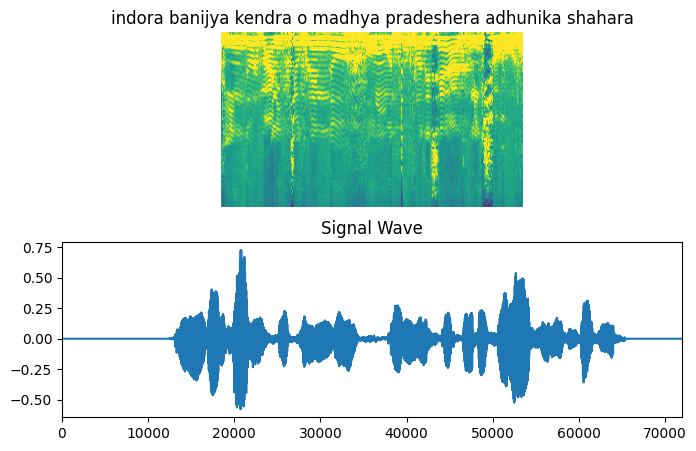

In [ ]:
# Visualisation
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["File Name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## Defining Model

In [ ]:
# Defining CTC Loss
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

In [ ]:

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

## Training and Evaluating

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [ ]:
# Define the number of epochs.
epochs = 2000
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)


Streaming output truncated to the last 5000 lines.
----------------------------------------------------------------------------------------------------
Target    : chora bajare apani gadira partasa theke bhiktoriyana porselina saba pabena
Prediction: shora badhara erahauia gkaira kasateke ubikporiana horshi i usabakaraea
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 4s 4s/step - loss: 3.1248 - val_loss: 323.1571
Epoch 1578/2000
1/1 [==============================] - 0s 110ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.1463
----------------------------------------------------------------------------------------------------
Target    : bandra theke kharera rastaya abhijata dakana theke phutapatera dokana sabai achhe
Prediction:  bana haraitekea kharera ra staea pouijtaratra dokarna htheke khub khatera dhokana sadriy

NotFoundError: ignored

## Predictions

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(len(targets[i]))
    print(f"Prediction: {predictions[i]}")
    print(len(predictions[i]))
    print("-" * 100)


1/1 [==============================] - 0s 261ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0976
----------------------------------------------------------------------------------------------------
Target    : bandra theke kharera rastaya abhijata dakana theke phutapatera dokana sabai achhe
81
Prediction: bana haraiteke kharera rasta pouijtatra dokarna theke khub katera dokana sariya yashye
86
----------------------------------------------------------------------------------------------------
Target    : mumbaite pradhana bajara jabheri bajara mangaladasa bajara dhabu strita o chora bajara
86
Prediction: mumbai te tora hana baya yara yadera i bajyara muhorla ta shora jyara  jhabrasthie ora shora haya yaya
102
----------------------------------------------------------------------------------------------------
Target    : bandra theke kharera rastaya abhijata dakana theke phutapatera dokana sabai achhe
81
Pr

**References:**

- [Speech recognition](https://en.wikipedia.org/wiki/Speech_recognition)
- [Sequence Modeling With CTC](https://distill.pub/2017/ctc/)
- [DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html)